In [1]:
import numpy as np
import matplotlib.pyplot as plt
from utils.notebook_config import *
import random
from utils.simulation2 import *

In [2]:
#This case: Large pool of TFs A,B,C, so we assume that p_a ,p_B and p_C are constant and both rna strings have the same probablilities. Also the unbound probabilities are the same as p_a, etc.


def simulation_dustin(probs: list, timesteps: int, shots: int):
    avg1, avg2, std1, std2 = [],[],[],[]
    total1, total2 = np.array([0 for i in range(timesteps)]), np.array([0 for i in range(timesteps)])

    avg_corr = np.array([[0,0],[0,0]])

    for z in range(shots):
        rna1 = [0,0,0]
        rna2 = [0,0,0]
        p_a, p_b, p_c, p_m1, p_m2, p_m3 = probs[0], probs[1], probs[2], probs[3], probs[4], probs[5]

        protein1, protein2 = [],[]                #amount of protein produced in every timestep

        for i in range(timesteps):

            prots1 = 0
            for i in rna1:
                if i != 0 and i != "M":
                    prots1 += 1
            protein1.append(prots1)
            prots2 = 0
            for i in rna2:
                if i != 0 and i != "M":
                    prots2 += 1
            protein2.append(prots2)

            order = np.random.permutation(6)       #random order
            for k in order:
                if k-3 < 0:
                    #########################        Check if empty --> Either A docks or M, depending on p_a/p_m
                    if k == 0 and rna1[k] == 0:
                        r1, r2 = random.random(), random.random()
                        if r1 <= p_a and r2 > p_m1:
                            rna1[k] = "A"
                            continue
                        elif r1 > p_a and r2 <= p_m1:
                            rna1[k] = "M"
                            continue
                    if k == 1 and rna1[k] == 0:
                        r1, r2 = random.random(), random.random()
                        if r1 <= p_a and r2 > p_m2:
                            rna1[k] = "B"
                            continue
                        elif r1 > p_a and r2 <= p_m2:
                            rna1[k] = "M"
                            continue
                    if k == 2 and rna1[k] == 0:
                        r1, r2 = random.random(), random.random()
                        if r1 <= p_a and r2 > p_m3:
                            rna1[k] = "C"
                            continue
                        elif r1 > p_a and r2 <= p_m3:
                            rna1[k] = "M"
                            continue
                    ###########################            Check if already A/B/C are docked --> undock depending p_a etc.
                    if k == 0 and rna1[k] == "A":
                        if random.random() <= p_a:
                            rna1[k] = 0
                            continue
                    if k == 1 and rna1[k] == "B":
                        if random.random() <= p_b:
                            rna1[k] = 0
                            continue
                    if k == 2 and rna1[k] == "C":
                        if random.random() <= p_c:
                            rna1[k] = 0
                            continue
                    #############################            Check for methylation --> un-methylize depending on p_m
                    if k == 0 and rna1[k] == "M":
                        if random.random() <= p_m1:
                            rna1[k] = 0
                            continue
                    if k == 1 and rna1[k] == "M":
                        if random.random() <= p_m2:
                            rna1[k] = 0
                            continue
                    if k == 2 and rna1[k] == "M":
                        if random.random() <= p_m3:
                            rna1[k] = 0
                            continue
                ############################################################### Do the same for the second rna!
                else:
                    k = k-3
                    if k == 0 and rna2[k] == 0:
                        r1, r2 = random.random(), random.random()
                        if r1 <= p_a and r2 > p_m1:
                            rna2[k] = "A"
                            continue
                        elif r1 > p_a and r2 <= p_m1:
                            rna2[k] = "M"
                            continue
                    if k == 1 and rna2[k] == 0:
                        r1, r2 = random.random(), random.random()
                        if r1 <= p_a and r2 > p_m2:
                            rna2[k] = "B"
                            continue
                        elif r1 > p_a and r2 <= p_m2:
                            rna2[k] = "M"
                            continue
                    if k == 2 and rna2[k] == 0:
                        r1, r2 = random.random(), random.random()
                        if r1 <= p_a and r2 > p_m3:
                            rna2[k] = "C"
                            continue
                        elif r1 > p_a and r2 <= p_m3:
                            rna2[k] = "M"
                            continue
                    ###########################            Check if already A/B/C are docked --> undock depending p_a etc.
                    if k == 0 and rna2[k] == "A":
                        if random.random() <= p_a:
                            rna2[k] = 0
                            continue
                    if k == 1 and rna2[k] == "B":
                        if random.random() <= p_b:
                            rna2[k] = 0
                            continue
                    if k == 2 and rna2[k] == "C":
                        if random.random() <= p_c:
                            rna2[k] = 0
                            continue
                    #############################            Check for methylation --> un-methylize depending on p_m
                    if k == 0 and rna2[k] == "M":
                        if random.random() <= p_m1:
                            rna2[k] = 0
                            continue
                    if k == 1 and rna2[k] == "M":
                        if random.random() <= p_m2:
                            rna2[k] = 0
                            continue
                    if k == 2 and rna2[k] == "M":
                        if random.random() <= p_m3:
                            rna2[k] = 0
                            continue
        total1 = np.vstack((total1, protein1))
        total2 = np.vstack((total2, protein2))
        avg_corr = avg_corr + np.corrcoef(protein1, protein2)
    total1 = np.delete(total1, (0), axis=0)
    total2 = np.delete(total2, (0), axis=0)
    for i in total1.T:
        avg1.append(np.mean(i))
        std1.append(np.std(i))
    for i in total2.T:
        avg2.append(np.mean(i))
        std2.append(np.std(i))
    avg_corr = avg_corr/shots
    time = [i for i in range(timesteps)]

    return time, avg1, std1, avg2, std2, avg_corr


In [3]:
probabilities  = np.random.rand(6)/5

time, avg1, std1, avg2, std2, avg_corr = simulation_dustin(probs=probabilities, timesteps=300, shots = 100)         

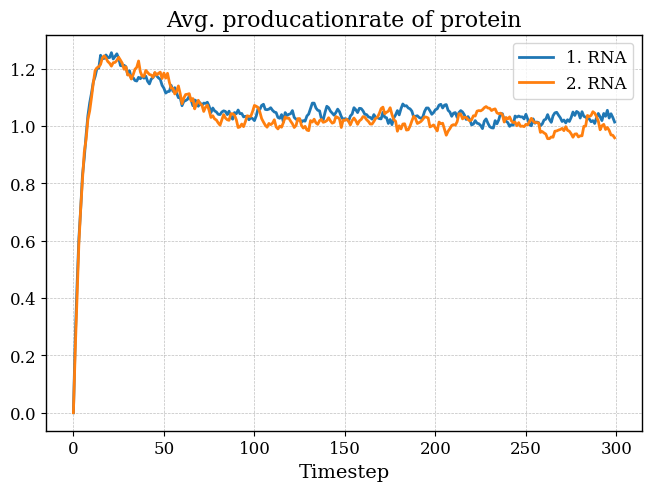

[[1.         0.01996878]
 [0.01996878 1.        ]]


In [4]:
probabilities = [0.08, 0.08, 0.08, 0.02, 0.02, 0.02]

time, avg1, std1, avg2, std2, avg_corr = simulation_dustin(probs=probabilities, timesteps=300, shots = 1000)   

plt.plot(time, avg1, label="1. RNA")
plt.plot(time, avg2, label="2. RNA")
plt.xlabel("Timestep")
plt.title("Avg. producationrate of protein")
plt.legend()
plt.show()

print(avg_corr)

In [14]:
#Work here with the defined classes in simulation2.py

p1 = 0.08

p2 = 0.02

# gene1 = gene(3, boxes, p1, p2)
# gene2 = gene(3, boxes, p1, p2)

simu = simulation(timesteps=200)

avg1, std1, avg2, std2, avg_corr = simu.average(3, p1, p2, 1000, m_switch=False)
avg1m, std1m, avg2m, std2m, avg_corrm = simu.average(3, p1, p2, 1000, m_switch=True)

avg1_10, std1_10, avg2_10, std2_10, avg_corr_10 = simu.average(10, p1, p2, 1000, m_switch=False)
avg1m_10, std1m_10, avg2m_10, std2m_10, avg_corrm_10 = simu.average(10, p1, p2, 1000, m_switch=True)

avg1_20, std1_20, avg2_20, std2_20, avg_corr_20 = simu.average(20, p1, p2, 1000, m_switch=False)
avg1m_20, std1m_20, avg2m_20, std2m_20, avg_corrm_20 = simu.average(20, p1, p2, 1000, m_switch=True)

/Users/dustinseboldt/Desktop/trafficRNA/utils/simulation2.py:51: RuntimeWarning: overflow encountered in scalar multiply
  self.meth_p[pos] = self.meth_p[pos]*(1+0.2*count)


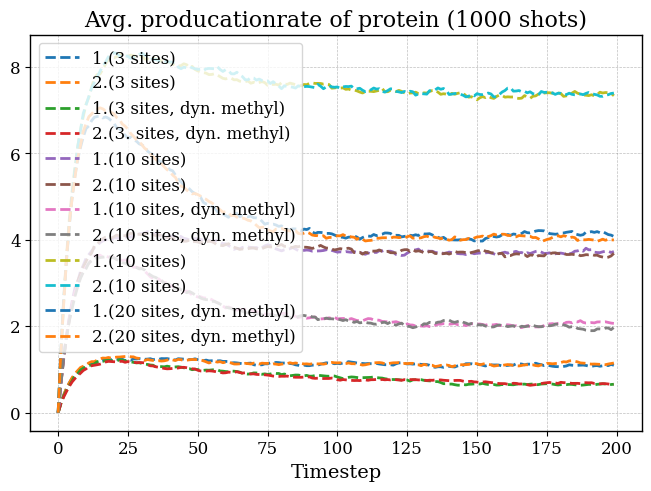

For 3 lattice sites:

Avg. Correlation bewteen the protein prodcution of each gene: 
 [[1.        0.0234284]
 [0.0234284 1.       ]]
Avg. Correlation bewteen the protein prodcution of each gene (with dyn. methlyzation being affected by neighbour): 
 [[1.         0.04258166]
 [0.04258166 1.        ]]

 For 10 lattice sites:

Avg. Correlation bewteen the protein prodcution of each gene: 
 [[1.         0.10053684]
 [0.10053684 1.        ]]
Avg. Correlation bewteen the protein prodcution of each gene (with dyn. methlyzation being affected by neighbour): 
 [[1.         0.12999446]
 [0.12999446 1.        ]]

 For 20 lattice sites:

Avg. Correlation bewteen the protein prodcution of each gene: 
 [[1.         0.17601701]
 [0.17601701 1.        ]]
Avg. Correlation bewteen the protein prodcution of each gene (with dyn. methlyzation being affected by neighbour): 
 [[1.         0.20039589]
 [0.20039589 1.        ]]


In [16]:
time = simu.timeline

plt.plot(time, avg1, label="1.(3 sites)", linestyle="--")
plt.plot(time, avg2, label="2.(3 sites)", linestyle="--")

plt.plot(time, avg1m, label="1.(3 sites, dyn. methyl)", linestyle="--")
plt.plot(time, avg2m, label="2.(3. sites, dyn. methyl)", linestyle="--")

plt.plot(time, avg1_10, label="1.(10 sites)", linestyle="--")
plt.plot(time, avg2_10, label="2.(10 sites)", linestyle="--")

plt.plot(time, avg1m_10, label="1.(10 sites, dyn. methyl)", linestyle="--")
plt.plot(time, avg2m_10, label="2.(10 sites, dyn. methyl)", linestyle="--")

plt.plot(time, avg1_20, label="1.(10 sites)", linestyle="--")
plt.plot(time, avg2_20, label="2.(10 sites)", linestyle="--")

plt.plot(time, avg1m_20, label="1.(20 sites, dyn. methyl)", linestyle="--")
plt.plot(time, avg2m_20, label="2.(20 sites, dyn. methyl)", linestyle="--")

plt.xlabel("Timestep")
plt.title("Avg. producationrate of protein (1000 shots)")
plt.legend()
plt.show()

print("For 3 lattice sites:\n")
print("Avg. Correlation bewteen the protein prodcution of each gene: \n", avg_corr)
print("Avg. Correlation bewteen the protein prodcution of each gene (with dyn. methlyzation being affected by neighbour): \n", avg_corrm)

print("\n For 10 lattice sites:\n")
print("Avg. Correlation bewteen the protein prodcution of each gene: \n", avg_corr_10)
print("Avg. Correlation bewteen the protein prodcution of each gene (with dyn. methlyzation being affected by neighbour): \n", avg_corrm_10)

print("\n For 20 lattice sites:\n")
print("Avg. Correlation bewteen the protein prodcution of each gene: \n", avg_corr_20)
print("Avg. Correlation bewteen the protein prodcution of each gene (with dyn. methlyzation being affected by neighbour): \n", avg_corrm_20)